# Sales Forecast and Analysis - Quod Financial Case Study
## Exploratory Data Analysis (EDA)

**Assignment Goal**: Build models for customer behavior analysis and prediction


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats


## 1. Data Loading and Initial Inspection

In [47]:
df1 = pd.read_csv('dataset/transactions_1.csv', index_col=0)
df2 = pd.read_csv('dataset/transactions_2.csv', index_col=0)

df1.head()

,customer_id,product_id,date
0,8649525,Opel,2017-01-31T09:31:08.873Z
1,8649525,Volkswagen,2017-02-03T16:59:16.610Z
2,8649525,Volkswagen,2017-02-05T19:47:55.353Z
3,8649525,Volkswagen,2017-02-05T19:48:14.633Z
4,8649525,Volkswagen,2017-02-06T09:59:49.053Z


In [48]:
df2.head()

,customer_id,product_id,date
500000,8822663,Abarth,2018-06-28T09:19:11.130Z
500001,8822663,Peugeot,2019-07-17T08:06:29.500Z
500002,8822663,Nissan,2017-06-22T07:29:22.440Z
500003,8822663,Nissan,2017-06-22T07:50:10.863Z
500004,8822663,Nissan,2017-06-22T08:40:35.923Z


In [49]:
print(f"dataset 1 shape is {df1.shape}")
print(f"dataset 2 shape is {df2.shape}")


dataset 1 shape is (500000, 3)
dataset 2 shape is (475955, 3)


In [50]:
# Combining the 2 datasets into 1 single dataset
df = pd.concat([df1, df2], ignore_index=True)
print(f"Combined dataset shape: {df.shape}")

Combined dataset shape: (975955, 3)


In [51]:
df[df['customer_id'] == 8649525]

,customer_id,product_id,date
0,8649525,Opel,2017-01-31T09:31:08.873Z
1,8649525,Volkswagen,2017-02-03T16:59:16.610Z
2,8649525,Volkswagen,2017-02-05T19:47:55.353Z
3,8649525,Volkswagen,2017-02-05T19:48:14.633Z
4,8649525,Volkswagen,2017-02-06T09:59:49.053Z
...,...,...,...
34958,8649525,Peugeot,2020-02-07T11:35:26.967Z
34959,8649525,Peugeot,2020-02-07T11:35:28.037Z
34960,8649525,Peugeot,2020-02-07T11:35:29.663Z
34961,8649525,Peugeot,2020-02-07T11:35:30.887Z


#### Missing values

In [52]:
print(f"Missing values: {df.isnull().sum()}")

Missing values: customer_id    0
product_id     0
date           0
dtype: int64


#### Duplicate Rows

In [53]:
print(f"Duplicate rows: {df.duplicated().sum()}")
df[df.duplicated(keep=False)]


Duplicate rows: 3


,customer_id,product_id,date
324723,1525871,Volkswagen,2017-10-19T08:15:47.840Z
324724,1525871,Volkswagen,2017-10-19T08:15:47.840Z
814552,6648127,Seat,2017-10-03T08:59:33.800Z
814553,6648127,Seat,2017-10-03T08:59:33.800Z
893455,2143682,Peugeot,2018-01-22T10:12:38.647Z
893456,2143682,Peugeot,2018-01-22T10:12:38.647Z


In [54]:
# Removed duplicated rows shown above to avoid counting the same transaction more than once and ensure accurate analysis
df = df.drop_duplicates(keep='first')


In [55]:
print(f"Duplicate rows: {df.duplicated().sum()}")
df[df.duplicated(keep=False)]


Duplicate rows: 0


,customer_id,product_id,date


### Outliers

In [56]:
customer_counts = df['customer_id'].value_counts()
customer_counts.describe()

count     2002.000000
mean       487.488511
std       1557.581049
min          1.000000
25%         20.250000
50%        103.000000
75%        394.000000
max      34963.000000
Name: count, dtype: float64

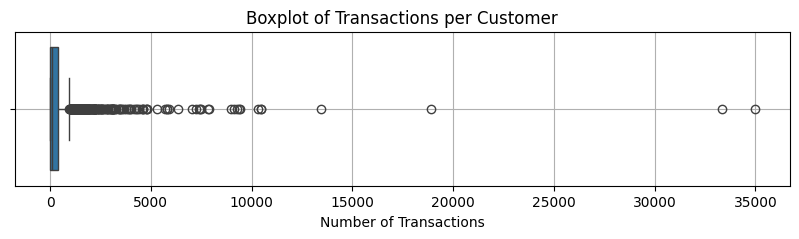

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 2))
sns.boxplot(x=customer_counts)

plt.title('Boxplot of Transactions per Customer')
plt.xlabel('Number of Transactions')
plt.grid(True)
plt.show()


In [58]:
df[df['customer_id'] == 8649525]['product_id']


0              Opel
1        Volkswagen
2        Volkswagen
3        Volkswagen
4        Volkswagen
            ...    
34958       Peugeot
34959       Peugeot
34960       Peugeot
34961       Peugeot
34962       Peugeot
Name: product_id, Length: 34963, dtype: object

I checked the outliers carefully instead of just removing them. Some customers made a very high number of purchases, like one who made over 35,000 transactions. At first it seemed unusual, but after looking into it, I saw they bought different types of cars, there were no duplicates, and the data looked clean.

So it’s likely this is a big company like uber — not an error. That’s why I decided to keep these outliers in the data, since they represent real and important behavior. I would only remove data if it looked clearly broken or duplicated.

since we are keeping these outliers, we should avoid using models that are sensitive to outliers, ike linear regression, instead tree based model are better.

#### Basic Infos 

In [59]:

print(f"Total transactions: {len(df):,}")
print(f"Unique customers: {df['customer_id'].nunique():,}")
print(f"Unique products: {df['product_id'].nunique()}")

df.info()

Total transactions: 975,952
Unique customers: 2,002
Unique products: 50
<class 'pandas.core.frame.DataFrame'>
Index: 975952 entries, 0 to 975954
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  975952 non-null  int64 
 1   product_id   975952 non-null  object
 2   date         975952 non-null  object
dtypes: int64(1), object(2)
memory usage: 29.8+ MB


## 2. Data Preprocessing

In [60]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df['date'].dtype

datetime64[ns, UTC]

In [61]:
# extract time features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['year_month'] = df['date'].dt.to_period('M')

C:\Users\dell\AppData\Local\Temp\ipykernel_23824\1593992897.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['date'].dt.to_period('M')


In [62]:
df

,customer_id,product_id,date,year,month,quarter,year_month
0,8649525,Opel,2017-01-31 09:31:08.873000+00:00,2017,1,1,2017-01
1,8649525,Volkswagen,2017-02-03 16:59:16.610000+00:00,2017,2,1,2017-02
2,8649525,Volkswagen,2017-02-05 19:47:55.353000+00:00,2017,2,1,2017-02
3,8649525,Volkswagen,2017-02-05 19:48:14.633000+00:00,2017,2,1,2017-02
4,8649525,Volkswagen,2017-02-06 09:59:49.053000+00:00,2017,2,1,2017-02
...,...,...,...,...,...,...,...
975950,1111821,Renault,2019-05-17 10:06:43.037000+00:00,2019,5,2,2019-05
975951,4232782,Renault,2017-10-27 17:49:54.483000+00:00,2017,10,4,2017-10
975952,4746355,Seat,2019-01-09 16:31:08.133000+00:00,2019,1,1,2019-01
975953,4743766,Opel,2017-03-29 16:25:05.907000+00:00,2017,3,1,2017-03


## 3. Customer Analysis

In [63]:
customer_counts = df['customer_id'].value_counts().sort_values(ascending=False)


In [64]:
customer_counts

customer_id
8649525    34963
1242611    33355
9467115    18927
1618902    13450
1435341    10490
           ...  
4232782        1
4746355        1
4743766        1
6014572        1
1249075        1
Name: count, Length: 2002, dtype: int64

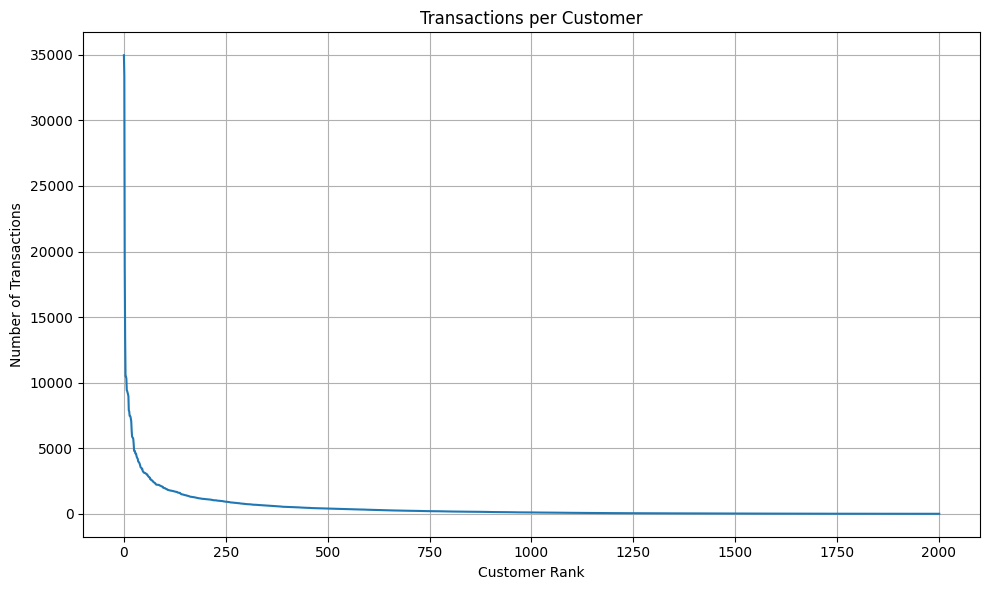

In [65]:

plt.figure(figsize=(10, 6))
plt.plot(customer_counts.values)
plt.xlabel('Customer Rank')
plt.ylabel('Number of Transactions')
plt.title('Transactions per Customer')
plt.grid(True)
plt.tight_layout()
plt.show()


In [66]:
customer_activity = df['customer_id'].value_counts().reset_index()
customer_activity.columns = ['customer_id', 'transaction_count']


This plot shows a long-tail pattern where small number of customers are responsible for a large number of transactions, while most customers are relatively inactive. This skewed distribution is important to consider during modeling, as it could lead to biased predictions favoring highly active users.

To reduce this problem, we'll create new features that look at how often customers make transactions (like transactions per month) rather than just counting total transactions. This way, a customer who makes 10 transactions in 1 month looks similar to a customer who makes 100 transactions in 10 months - they both have the same monthly rate. This helps our model learn from all customers fairly, not just the super active ones.



#### Activity Level Feature

Some customers buy a lot, others only a few times, so their behavior is very different. To help the model understand this, we added a new feature called Activity with 4 levels levels: Inactive, Low, Medium and High activity.
This makes the data easier to work with and helps the model make better predictions. For example, someone who made 400 purchases in the past is clearly not the same as someone who only bought once, and the model needs to know that.


## 4. Product Analysis

In [67]:
df_2018 = df[df['year'] == 2018].copy()

In [29]:
df_2018

,customer_id,product_id,date,year,month,quarter,year_month
63,8649525,Fiat,2018-01-16 13:07:27.963000+00:00,2018,1,1,2018-01
64,8649525,Fiat,2018-01-16 13:28:36.980000+00:00,2018,1,1,2018-01
65,8649525,Peugeot,2018-03-07 08:39:30.840000+00:00,2018,3,1,2018-03
66,8649525,Peugeot,2018-03-07 09:20:08.520000+00:00,2018,3,1,2018-03
67,8649525,BMW,2018-03-16 13:44:43.823000+00:00,2018,3,1,2018-03
...,...,...,...,...,...,...,...
975939,6129479,Ford,2018-01-30 10:00:10.173000+00:00,2018,1,1,2018-01
975940,9621397,Seat,2018-02-24 06:51:19.860000+00:00,2018,2,1,2018-02
975942,5187290,Volkswagen,2018-04-05 08:56:04.600000+00:00,2018,4,2,2018-04
975946,4083230,Toyota,2018-07-17 16:17:24.950000+00:00,2018,7,3,2018-07


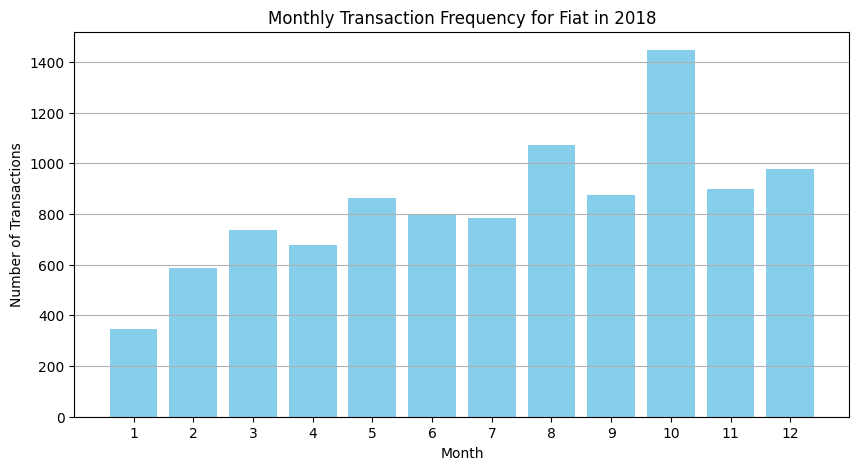

In [68]:
def plot_product_monthly_trend(df, product_name):
    product_df = df[df['product_id'] == product_name]

    monthly_counts = product_df['month'].value_counts().sort_index() 

    plt.figure(figsize=(10, 5))
    plt.bar(monthly_counts.index, monthly_counts.values, color='skyblue')
    plt.title(f"Monthly Transaction Frequency for {product_name} in 2018")
    plt.xlabel("Month")
    plt.ylabel("Number of Transactions")
    plt.xticks(range(1, 13))
    plt.grid(axis='y')
    plt.show()
    
plot_product_monthly_trend(df_2018, "Fiat")



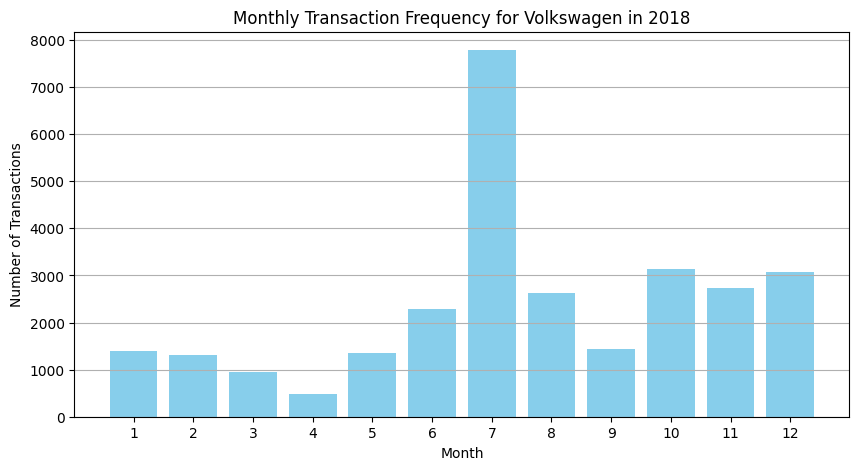

In [69]:
plot_product_monthly_trend(df_2018, "Volkswagen")

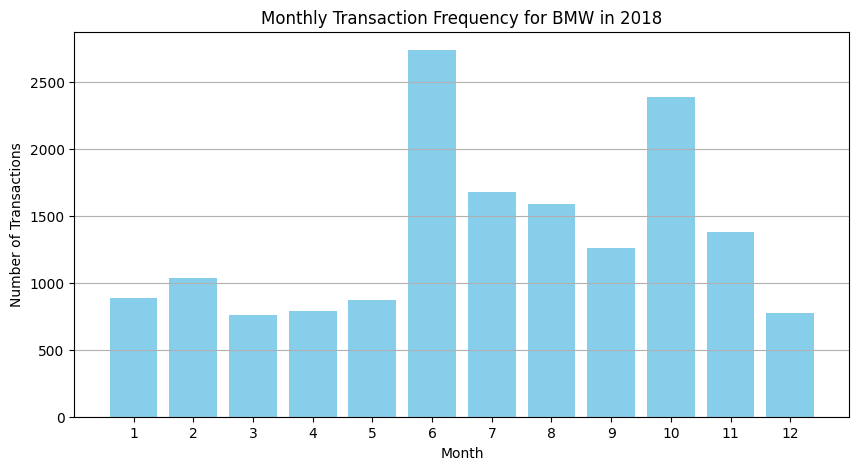

In [70]:
plot_product_monthly_trend(df_2018, "BMW")

## 5. Top 5 products & Seasonality Analysis

In [71]:
def top_products_last_6_months(df, reference_date):
    top_n = 5
    ref_date = pd.to_datetime(reference_date, utc=True)
    start_date = ref_date - pd.DateOffset(months=6)
    df_window = df[(df['date'] >= start_date) & (df['date'] <= ref_date)]
    return df_window['product_id'].value_counts().head(top_n)


top_products_last_6_months(df, '2018-12-31')



product_id
Renault       35796
Volkswagen    20789
Peugeot       15881
Opel          14956
Citroen        9562
Name: count, dtype: int64

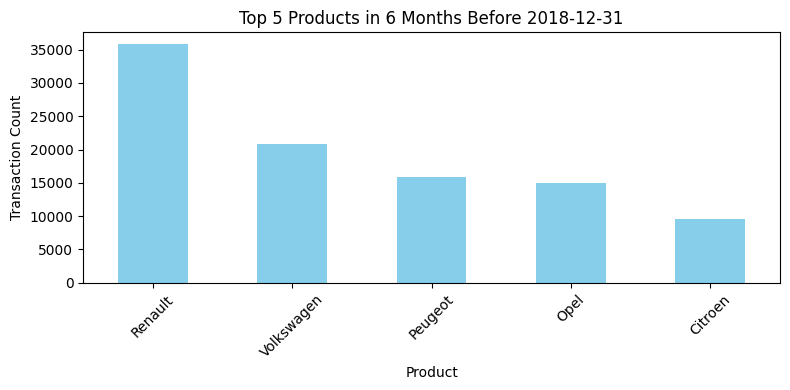

In [72]:
def plot_top_products_bar(df, reference_date):
    top_products = top_products_last_6_months(df, reference_date)
    
    plt.figure(figsize=(8, 4))
    top_products.plot(kind='bar', color='skyblue')
    plt.title(f'Top 5 Products in 6 Months Before {reference_date}')
    plt.xlabel('Product')
    plt.ylabel('Transaction Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_top_products_bar(df, '2018-12-31')

#### Seasonality

In [81]:
def plot_monthly_seasonality(df):

    monthly = df.groupby(['year', 'month']).size().reset_index(name='count')
    years = sorted(monthly['year'].unique())
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Line chart by year
    plt.figure(figsize=(14, 6))
    for year in years:
        plt.plot(
            monthly[monthly['year'] == year]['month'],
            monthly[monthly['year'] == year]['count'],
            marker='o', label=f'{year}'
        )
    plt.xticks(range(1, 13), months)
    plt.title('Monthly Transactions by Year')
    plt.xlabel('Month')
    plt.ylabel('Transactions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Bar chart of average + std
    monthly_avg = monthly.groupby('month')['count'].agg(['mean', 'std'])

    plt.figure(figsize=(12, 5))
    plt.bar(
        range(1, 13), monthly_avg['mean'],
        yerr=monthly_avg['std'], capsize=5,
        color='skyblue', edgecolor='navy'
    )
    plt.xticks(range(1, 13), months)
    plt.title('Average Monthly Transactions (All Years)')
    plt.xlabel('Month')
    plt.ylabel('Avg Transactions')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


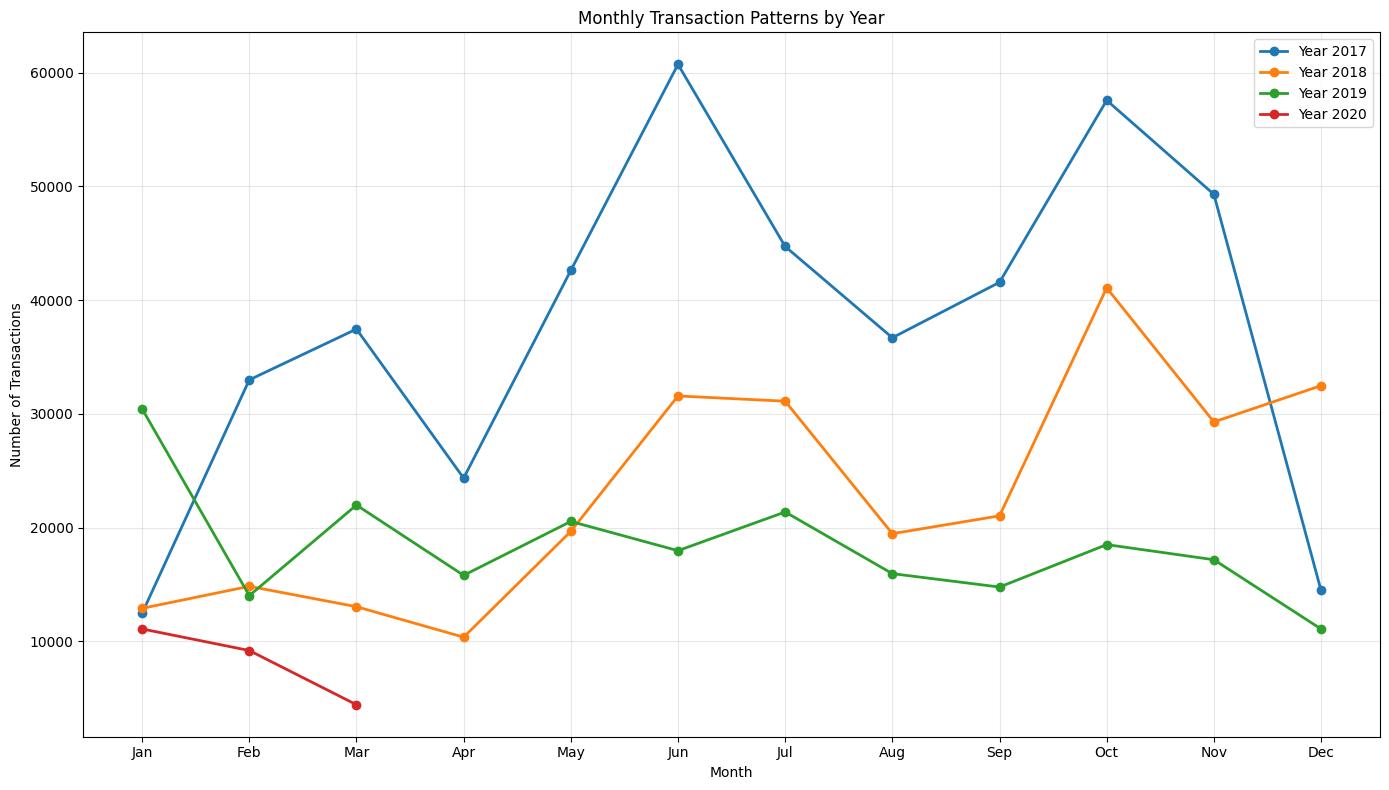

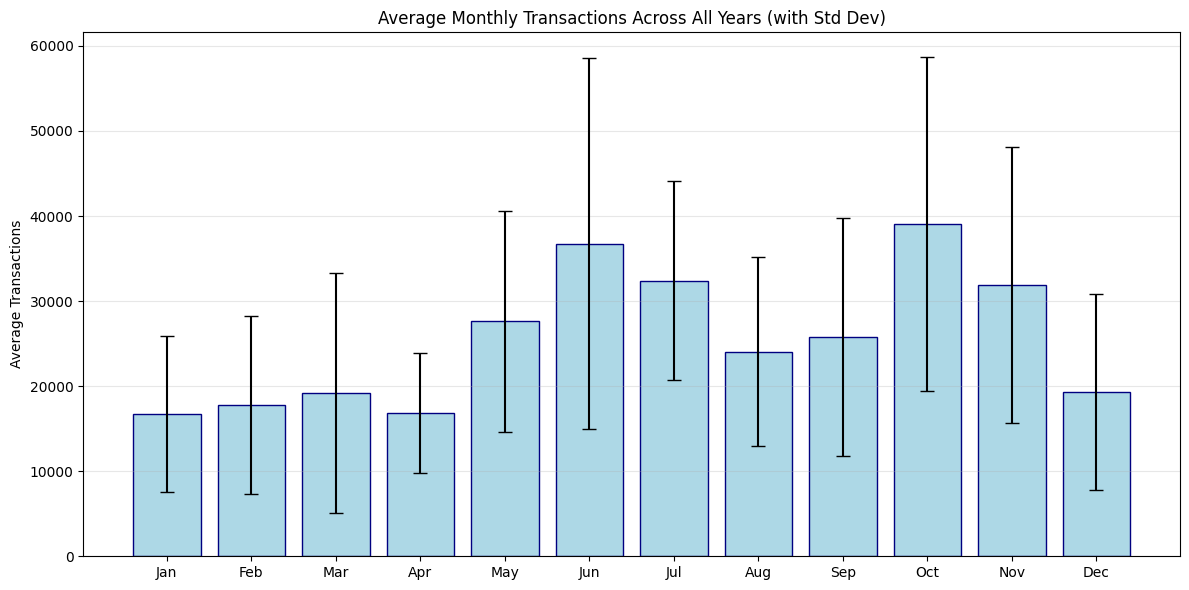

In [78]:
plot_monthly_seasonality(df)

#### The charts show some possible seasonality, but it’s not very consistent. For example, we see clear spikes in June during 2017 and 2018, but that pattern doesn’t hold in the following years.
#### In the average monthly chart, June and October do stand out with higher transaction volumes, but the large error bars (standard deviations) suggest that the numbers vary a lot from year to year.
#### So while there might be some seasonal trends, they’re not stable. I’ll run an ANOVA test to confirm if these month-to-month differences are statistically significant.

In [87]:
def anova_test(df):
    monthly = df.groupby(['year', 'month']).size().reset_index(name='count')
    groups = [group['count'].values for _, group in monthly.groupby('month')]

    _, p_value = stats.f_oneway(*groups)

    if p_value < 0.05:
        print(f" p_value is :{p_value}, Seasonality detected (p-value < 0.05)")
    else:
        print(f"p_value is :{p_value}, No clear seasonality (p-value >= 0.05)")

anova_test(df)

p_value is :0.40058730063748876, No clear seasonality (p-value >= 0.05)


## 6. Extra Questions

### 6.1 - How long does a customer wait before transacting again?

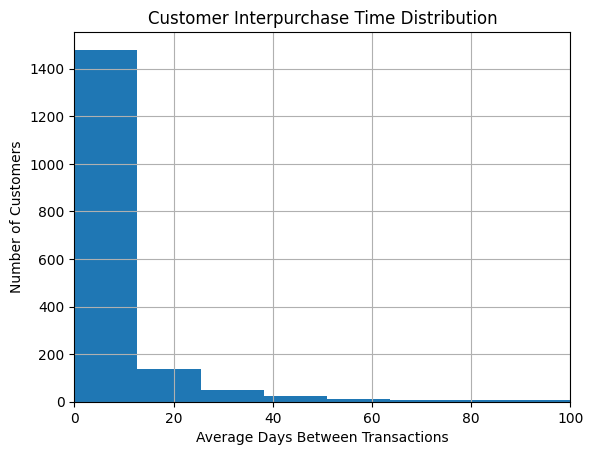

In [ ]:
# Filter data before cutoff 
cutoff = pd.to_datetime('2019-01-31', utc=True)
df_filtered = df[df['date'] <= cutoff]

# Sort by customer and date
df_filtered = df_filtered.sort_values(['customer_id', 'date'])

# Calculate time difference between each transaction
df_filtered['days_since_prev'] = df_filtered.groupby('customer_id')['date'].diff().dt.days

# Now calculate the average wait time per customer
interpurchase = df_filtered.groupby('customer_id')['days_since_prev'].mean().reset_index()
interpurchase.columns = ['customer_id', 'avg_days_between_tx']

plt.hist(interpurchase['avg_days_between_tx'].dropna(), bins=50)
plt.xlabel('Average Days Between Transactions')
plt.ylabel('Number of Customers')
plt.title('Customer Interpurchase Time Distribution')
plt.xlim(0, 100) 
plt.grid(True)
plt.show()


In [ ]:
print(interpurchase['avg_days_between_tx'].describe())

count    1742.000000
mean        9.391909
std        32.744469
min         0.000000
25%         0.775522
50%         2.503731
75%         7.196392
max       636.000000
Name: avg_days_between_tx, dtype: float64


In [ ]:
interpurchase

,customer_id,avg_days_between_tx
0,1001614,4.433962
1,1005846,0.000000
2,1006880,2.268852
3,1014379,0.000000
4,1014759,20.315789
...,...,...
1812,9986806,10.867925
1813,9987263,1.680412
1814,9993221,0.593449
1815,9993896,4.470588


Most customers repurchase within 7 days, while a few wait much longer. This pattern could be useful for predicting future transactions.


### 6.2 - Does product diversity correlate with transaction frequency?


In [ ]:
cutoff = pd.to_datetime('2019-01-31', utc=True)
df_filtered = df[df['date'] <= cutoff]

customer_stats = df_filtered.groupby('customer_id').agg({
    'product_id': 'nunique',
    'date': 'count'
}).rename(columns={'product_id': 'num_products', 'date': 'num_transactions'})

customer_stats

,num_products,num_transactions
customer_id,,
1001614,10,54
1005846,4,7
1006880,17,306
1014379,5,12
1014759,4,20
...,...,...
9986806,2,54
9987263,16,389
9993221,17,520


In [ ]:
# Check correlation
correlation = customer_stats['num_products'].corr(customer_stats['num_transactions'])
print(f"Correlation between product diversity and transaction count: {correlation}")

Correlation between product diversity and transaction count: 0.529086247602641


Text(0.5, 1.0, 'Product Diversity vs Transaction Frequency')

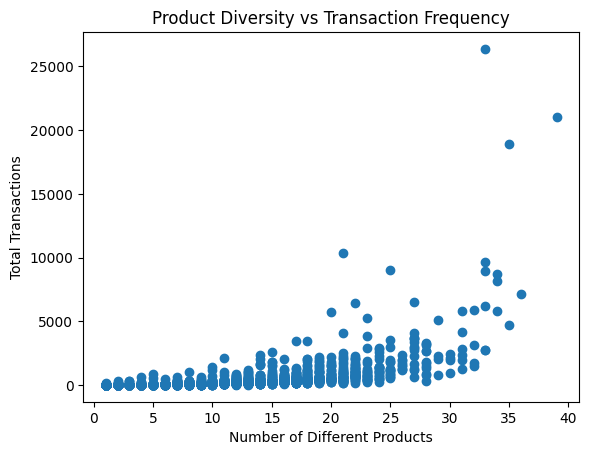

In [ ]:
plt.scatter(customer_stats['num_products'], customer_stats['num_transactions'])
plt.xlabel('Number of Different Products')
plt.ylabel('Total Transactions')
plt.title('Product Diversity vs Transaction Frequency')

we got a moderate to strong correlation 0.51,and it was confirmed in the plot, so this feature should be definetly added, as it has moderate predictive power

### 6.3 - Do customers who are buying more lately, keep buying more?

In [ ]:
cutoff = pd.to_datetime('2019-01-31', utc=True)
df_filtered = df[df['date'] <= cutoff]

# Define 90-day windows
recent_start = cutoff - pd.Timedelta(days=45)
past_start = cutoff - pd.Timedelta(days=90)
past_end = recent_start

# Filter transactions in each window
recent = df_filtered[df_filtered['date'] > recent_start]
past = df_filtered[(df_filtered['date'] > past_start) & (df_filtered['date'] <= past_end)]

# Count transactions per customer
recent_count = recent.groupby('customer_id').size().reset_index(name='recent_tx')
past_count = past.groupby('customer_id').size().reset_index(name='past_tx')

# Merge and compute acceleration
acc_stats = pd.merge(recent_count, past_count, on='customer_id', how='outer').fillna(0)
acc_stats['tx_acceleration'] = acc_stats['recent_tx'] - acc_stats['past_tx']

# Correlation with recent_tx (optional)
correlation = acc_stats['tx_acceleration'].corr(acc_stats['recent_tx'])
print(f"Correlation between 90-day acceleration and recent transactions: {correlation:.3f}")


Correlation between 90-day acceleration and recent transactions: 0.173


The transaction acceleration feature shows a low correlation (0.17–0.37) depending on the time window, so it could be a weak predictor.
We will test model performance with and without this feature to evaluate its actual contribution before deciding whether to keep it

In [ ]:
df.to_csv('dataset/cleaned_dataset.csv', index=False)
